In [6]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from sklearn.pipeline import make_pipeline
from sklearn import svm, neighbors, ensemble, preprocessing
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [7]:
train = pd.read_csv('train.csv')

In [9]:
#create a species dictionary to convert species to numerical values
species_list = train['species'].unique().tolist()
species_dict = {}
for i,item in enumerate(species_list):
    species_dict[item] = i
train['species_id'] = train['species'].apply(lambda x: species_dict[x])
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,species_id
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391,0
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461,1
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930,2
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852,3
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250,4


#Now build a basic RF classifier for the pipeline

In [10]:
X = train.iloc[:, 2: 194]
y = train.iloc[:, 194]
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [39]:
#Build an optimizer for the best RF 
n_features = 192
n_examples = len(df)
def optimized_classifier(X, y, classifier, distributions, scorer='f1_weighted', n_iter=30, cv=3):
    """
    Return best classifier and scores for X,y from a randomized search over parameters

    X             -- Features for each sample
    y             -- Class label for each sample
    classifier    -- An estimator class or pipeline from sklearn
    distributions -- The parameter distributions to search for that estimator
    scorer        -- Scoring function (e.g. accuracy or f1)
    n_iter        -- The number of random iterations to try
    """
    # Make a pipeline out of the classifier, to allow for feature scaling in the first step.

    # Add prefix to parameters to support use in pipeline
    class_name = classifier.__class__.__name__.lower()
    distributions = dict((class_name + "__" + key, val) for key, val in distributions.iteritems())

    # It is important to handle scaling here so we don't accidentally overfit some to the
    # test data by scaling using that information as well.
    classifier = make_pipeline(preprocessing.RobustScaler(), classifier)
    randomized_search = RandomizedSearchCV(
        classifier, param_distributions=distributions, n_iter=n_iter, scoring=scorer, cv=cv, n_jobs=1)
    randomized_search.fit(X, y)

    print randomized_search.best_estimator_
    print "Validation Score ({}): {:.2f}".format(scorer, randomized_search.best_score_)
    print ""
    return [randomized_search.best_estimator_, randomized_search.best_score_]
rfc_params = {"n_estimators": [100],
                    "criterion": ["gini", "entropy"],
                  "max_features": np.linspace(np.sqrt(n_features) / 2, np.sqrt(n_features) * 2, 5).astype(int),
                  "max_depth": range(3, 7),
                  "min_samples_split": np.linspace(2, n_examples / 50, 10).astype(int)}
rf = optimized_classifier(X_train, y_train, RandomForestClassifier(), rfc_params)

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipeline(steps=[('robustscaler', RobustScaler(copy=True, with_centering=True, with_scaling=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features=27, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Validation Score (f1_weighted): 0.92



#Which features are important?
Let's take a look using Sci-Kit Learn's built-in features to ascertain which ones are important

In [11]:
my_rf = RandomForestClassifier(bootstrap = True, class_weight = None, 
                              criterion = 'entropy', max_depth = 6, 
                              max_features = 27, max_leaf_nodes = None, 
                              min_samples_leaf = 1, min_samples_split = 3, 
                              min_weight_fraction_leaf = 0.0, n_estimators = 100, 
                              n_jobs = 1, oob_score = False, random_state = None, 
                              verbose = 0, warm_start = False)
rf_fit = my_rf.fit(X_train, y_train)

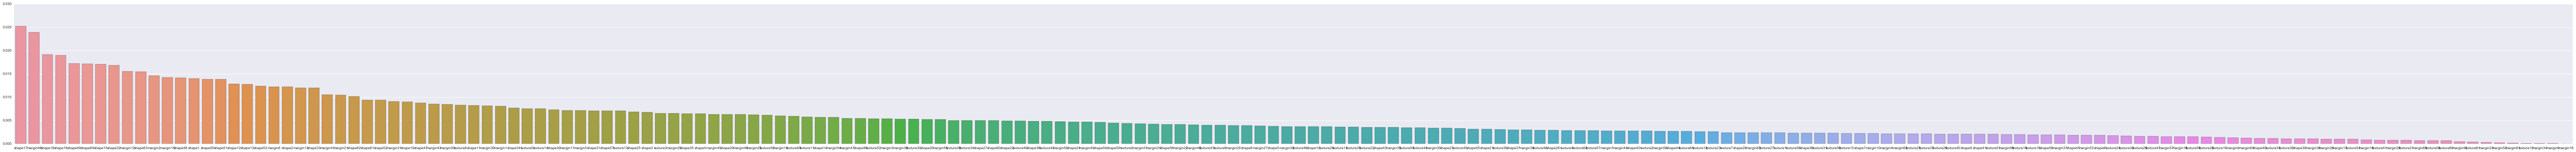

In [47]:
%matplotlib inline
from sklearn.datasets import make_classification
importances = rf_fit.feature_importances_
importance_key = {}
features = X_train.columns
importances, features = zip(*sorted(zip(importances, features)))
importances = importances[::-1]
features = features[::-1]
#plot the figure
fig, ax = plt.subplots()
ax = sns.barplot(x = features, y = importances)
fig.set_size_inches(100, 6)
plt.tight_layout()
plt.show()

In [45]:
#It will be easier to just see this represented in a dataframe since there are SO many features!
df = pd.DataFrame()
df['feature'] = features
df['importance'] = importances
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_], axis=0) 
df['errors'] = std
df

,feature,importance,errors
0,shape17,0.025191,0.013737
1,margin48,0.023878,0.023042
2,shape18,0.019172,0.009672
3,shape16,0.018995,0.004352
4,shape49,0.017199,0.013831
5,shape64,0.017167,0.018045
6,shape15,0.017035,0.006199
7,shape32,0.016840,0.000397
8,margin12,0.015533,0.003360
9,shape63,0.015487,0.005392


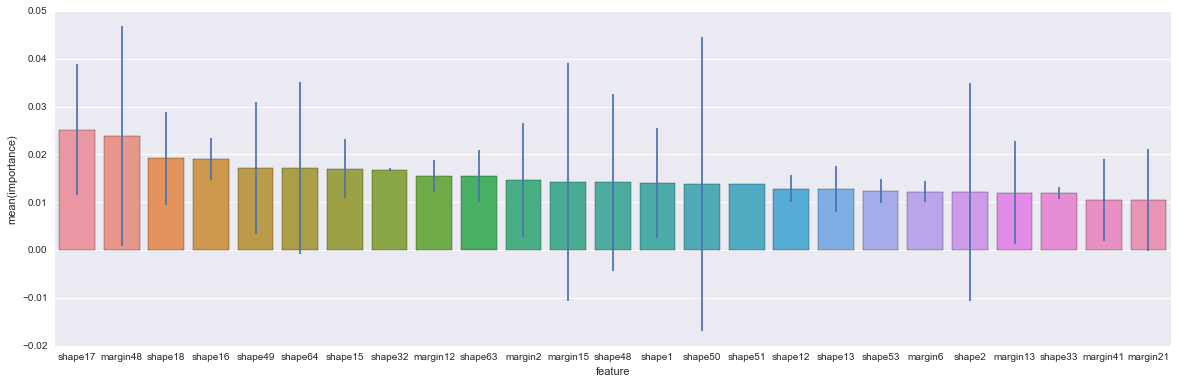

In [53]:
#Maybe we will just plot the top 25 features? Too much to deal with otherwise!
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
df1 = df.iloc[0:25, :]
sns.barplot(x = 'feature', y = 'importance', yerr = df1['errors'], data = df1)
plt.show()